In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, roc_curve, auc, plot_roc_curve, classification_report
from sklearn import model_selection


In [2]:
rooth_path = '../rawdata/outro/'
generator_df = pd.read_csv(rooth_path + 'generator_df.csv')
gen_bear_df = pd.read_csv(rooth_path + 'gen_bear_df.csv')
hyd_df = pd.read_csv(rooth_path + 'hyd_df.csv')
gearbox_df = pd.read_csv(rooth_path + 'gearbox_df.csv')
transf_df = pd.read_csv(rooth_path + 'transf_df.csv')

In [3]:
generator_df['Timestamp'] = pd.to_datetime(generator_df['Timestamp'])
gen_bear_df['Timestamp'] = pd.to_datetime(gen_bear_df['Timestamp'])
hyd_df['Timestamp'] = pd.to_datetime(hyd_df['Timestamp'])
gearbox_df['Timestamp'] = pd.to_datetime(gearbox_df['Timestamp'])
transf_df['Timestamp'] = pd.to_datetime(transf_df['Timestamp'])

In [4]:
#By Pearson corr analysis
features_drop = ['Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_Phase1_Temp_Avg','Gen_Phase3_Temp_Avg', 'Amb_WindSpeed_Est_Avg',
                'Grd_RtrInvPhase1_Temp_Avg', 'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min','Grd_Prod_VoltPhse2_Avg',
                'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min', 'Prod_LatestAvg_ReactPwrGen1', 'Cont_Hub_Temp_Avg',
                'Spin_Temp_Avg', 'Rtr_RPM_Std', 'Rtr_RPM_Avg', 'Cont_VCP_Temp_Avg', 'Grd_Prod_CurPhse1_Avg', 'Prod_LatestAvg_TotActPwr',
                 'Grd_Prod_CurPhse3_Avg', 'Grd_Prod_Pwr_Max', 'Grd_Prod_Pwr_Min', 'HVTrafo_Phase1_Temp_Avg', 'Grd_Prod_CurPhse2_Avg',
                 'HVTrafo_Phase3_Temp_Avg', 'Grd_Prod_PsblePwr_Max', 'Grd_Prod_PsblePwr_Min', 'Grd_Prod_ReactPwr_Avg',
                'Grd_Prod_PsbleInd_Max', 'Grd_Prod_PsbleInd_Min', 'Prod_LatestAvg_ActPwrGen1', 'Prod_LatestAvg_TotReactPwr',
                'Grd_Prod_PsbleInd_Avg', 'Blds_PitchAngle_Avg', 'Grd_Prod_ReactPwr_Max', 'Grd_Prod_ReactPwr_Min',
                'Nac_Direction_Avg', 'Amb_WindDir_Abs_Avg', 'Grd_Prod_PsbleCap_Min', 'Gear_Oil_Temp_Avg', 'Grd_Prod_VoltPhse1_Avg']

In [5]:
## Remove columns with strong correlations
generator_df = generator_df.drop(columns=features_drop)
gen_bear_df = gen_bear_df.drop(columns=features_drop)
hyd_df = hyd_df.drop(columns=features_drop)
gearbox_df = gearbox_df.drop(columns=features_drop)
transf_df = transf_df.drop(columns=features_drop)

In [6]:
def prepare_train_test(df):
    last_date = df['Timestamp'].iloc[-1]
    split = last_date - pd.DateOffset(months=3)
    df_train = df[df['Timestamp'] < split]
    df_test = df[df['Timestamp'] >= split]
    
    return df_train, df_test

In [7]:
generator_df_train, generator_df_test = prepare_train_test(generator_df)
gen_bear_df_train, gen_bear_df_test = prepare_train_test(gen_bear_df)
hyd_df_train, hyd_df_test = prepare_train_test(hyd_df)
gearbox_df_train, gearbox_df_test = prepare_train_test(gearbox_df)
transf_df_train, transf_df_test = prepare_train_test(transf_df)

In [8]:
#Group by day per turbine
def group_per_frequency(df, strategy='mean'):
    df['Date'] = df['Timestamp'].dt.date
    if strategy == 'max':
        df = df.groupby(by=['Turbine_ID','Date']).max().reset_index().drop(columns='Timestamp')
    else:
        df = df.groupby(by=['Turbine_ID','Date']).mean().reset_index()
        
    return df

In [9]:
df_train_gearbox_day = group_per_frequency(gearbox_df_train)
df_train_gen_day = group_per_frequency(generator_df_train)
df_train_gen_bear_day = group_per_frequency(gen_bear_df_train)
df_train_hyd_day = group_per_frequency(hyd_df_train)
df_train_transf_day = group_per_frequency(transf_df_train)
df_test_gearbox_day = group_per_frequency(gearbox_df_test)
df_test_gen_day = group_per_frequency(generator_df_test)
df_test_gen_bear_day = group_per_frequency(gen_bear_df_test)
df_test_hyd_day = group_per_frequency(hyd_df_test)
df_test_transf_day = group_per_frequency(transf_df_test)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
dfs = [df_train_gearbox_day,df_train_gen_day, df_train_gen_bear_day, df_train_hyd_day, df_train_transf_day,
       df_test_gearbox_day, df_test_gen_day, df_test_gen_bear_day, df_test_hyd_day, df_test_transf_day ]

for df in dfs:
    df['60_days'] = df['60_days'].round(decimals=0)
    df['50_days'] = df['50_days'].round(decimals=0)
    df['40_days'] = df['40_days'].round(decimals=0)
    df['30_days'] = df['30_days'].round(decimals=0)
    df['20_days'] = df['20_days'].round(decimals=0)
    df['10_days'] = df['10_days'].round(decimals=0)

In [11]:
def add_features(df_in, rolling_win_size):
    
    sensor_cols = []
    for i in df_in.keys()[2:-8]:
        sensor_cols.append(i)
    sensor_av_cols = [nm+'_av' for nm in sensor_cols]
    sensor_sd_cols = [nm+'_sd' for nm in sensor_cols]
    df_out = pd.DataFrame()
    ws = rolling_win_size
    #calculate rolling stats for each engine id
    for m_id in pd.unique(df_in.Turbine_ID):
        # get a subset for each engine sensors
        df_engine = df_in[df_in['Turbine_ID'] == m_id]
        df_sub = df_engine[sensor_cols]
        # get rolling mean for the subset
        av = df_sub.rolling(ws, min_periods=1).mean()
        av.columns = sensor_av_cols
        # get the rolling standard deviation for the subset
        sd = df_sub.rolling(ws, min_periods=1).std().fillna(0)
        sd.columns = sensor_sd_cols
        # combine the two new subset dataframes columns to the engine subset
        new_ftrs = pd.concat([df_engine,av,sd], axis=1)
        # add the new features rows to the output dataframe
        df_out = pd.concat([df_out,new_ftrs])
    return df_out

In [12]:
df_train_gearbox_extra = add_features(df_train_gearbox_day, 30)
df_train_gen_extra = add_features(df_train_gen_day, 30)
df_train_gen_bear_extra = add_features(df_train_gen_bear_day, 30)
df_train_hyd_extra = add_features(df_train_hyd_day, 30)
df_train_transf_extra = add_features(df_train_transf_day, 30)
df_test_gearbox_extra = add_features(df_test_gearbox_day, 30)
df_test_gen_extra = add_features(df_test_gen_day, 30)
df_test_gen_bear_extra = add_features(df_test_gen_bear_day, 30)
df_test_hyd_extra = add_features(df_test_hyd_day, 30)
df_test_transf_extra = add_features(df_test_transf_day, 30)

In [13]:
#Failures Generator in train data - T06 and T11
#Failures Hydraulic Group in train data - T06 and T11
#Failures Gen_bear in train data - T07 and T09
#Failures Transformer in train data - T07
# Gearbox -> Change train_test in order to be 1 failure in test data

In [14]:
df_train_gen = df_train_gen_extra.loc[(df_train_gen_extra['Turbine_ID']=='T06') | (df_train_gen_extra['Turbine_ID']=='T11')]
df_train_gen_bear = df_train_gen_bear_extra.loc[(df_train_gen_bear_extra['Turbine_ID']=='T07') | (df_train_gen_bear_extra['Turbine_ID']=='T09')]
df_train_hyd = df_train_hyd_extra.loc[(df_train_hyd_extra['Turbine_ID']=='T06') | (df_train_hyd_extra['Turbine_ID']=='T11')]
df_train_transf = df_train_transf_extra.loc[df_train_transf_extra['Turbine_ID']=='T07']
df_test_gen = df_test_gen_extra.copy()
df_test_gen_bear = df_test_gen_bear_extra.copy()
df_test_hyd = df_test_hyd_extra.copy()
df_test_transf = df_test_transf_extra.copy()

In [16]:
#Scaling
def scale(df_train, df_test, scaler='StandardScaler'):
    
    for m_id in pd.unique(df_train.Turbine_ID):
        X_train = df_train.drop(columns=['Date', 'TTF', '60_days', '50_days', '40_days', '30_days', '20_days', '10_days', 'Component', 'Turbine_ID']) 
        X_test = df_test.drop(columns=['Date', 'TTF', '60_days', '50_days', '40_days', '30_days', '20_days', '10_days', 'Component', 'Turbine_ID'])
        if scaler == 'MinMaxScaler':
            sc = MinMaxScaler()
            X_train_scale = sc.fit_transform(X_train)
            X_test_scale = sc.transform(X_test)
        else:
            sc = StandardScaler()
            X_train_scale = sc.fit_transform(X_train)
            X_test_scale = sc.transform(X_test)

        
    return X_train_scale, X_test_scale

In [17]:
def bin_classify(model, clf, X_train, X_test, y_train, y_test, params=None, score=None, ):
      
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    if hasattr(grid_search, 'predict_proba'):   
        y_score = grid_search.predict_proba(X_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
        
    predictions = {'y_pred' : y_pred, 'y_score' : y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    return grid_search.best_estimator_, df_predictions

In [18]:
def metrics(estimator, X_test, y_test, y_pred):
    
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    plot_roc_curve(estimator, X_test, y_test)

In [34]:
def rfc(X_train, X_test, y_train, y_test):
    model = 'Random Forest Classifier'
    clf_rfc = RandomForestClassifier(random_state=42)
    gs_params = {'n_estimators': [300, 500, 750, 800, 900, 1000], 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced', None]}
    gs_score = 'f1'

    clf_rfc, pred_rfc= bin_classify(model, clf_rfc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_rfc)

    metrics(clf_rfc, X_test, y_test, pred_rfc['y_pred'])

In [35]:
def gbc(X_train, X_test, y_train, y_test):
    model = 'Gradient Boosting Classifier'
    clf_gbc = GradientBoostingClassifier(random_state=42)
    gs_params = {'learning_rate': [0.001, 0.01, 0.1, 0.5, 1], 'n_estimators': [100, 200, 500, 700]}
    gs_score = 'f1'

    clf_gbc, pred_gbc= bin_classify(model, clf_gbc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_gbc)

    metrics(clf_gbc, X_test, y_test, pred_gbc['y_pred'])

In [36]:
def knn(X_train, X_test, y_train, y_test):
    model = 'KNN'
    clf_knn = KNeighborsClassifier()
    gs_params = {'n_neighbors': [5, 7, 10, 15], 'weights': ['uniform', 'distance']}
    gs_score = 'f1'

    clf_knn, pred_knn= bin_classify(model, clf_knn, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_knn)

    metrics(clf_knn, X_test, y_test, pred_knn['y_pred'])

In [37]:
def abc(X_train, X_test, y_train, y_test):
    model = 'AdaBoostClassifier'
    clf_abc = AdaBoostClassifier(random_state=42)
    gs_params = {'n_estimators': [50, 100, 200, 300, 500]}
    gs_score = 'f1'

    clf_abc, pred_abc= bin_classify(model, clf_abc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_abc)

    metrics(clf_abc, X_test, y_test, pred_abc['y_pred'])

In [38]:
def svc(X_train, X_test, y_train, y_test):
    model = 'SVC'
    clf_svc = SVC(random_state=42)
    gs_params = {'C': [0.01, 0.1, 1, 1.2], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2,3], 'class_weight': ['balanced', None], 'gamma': ['auto', 'scale']}
    gs_score = 'f1'

    clf_svc, pred_svc= bin_classify(model, clf_svc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_svc)

    metrics(clf_svc, X_test, y_test, pred_svc['y_pred'])

# GENERATOR

In [39]:
feat_drop = ['Date', 'TTF', '60_days', '50_days', '40_days', '30_days', '20_days', '10_days', 'Component', 'Turbine_ID']
X_train_gen = df_train_gen.drop(columns=feat_drop)
X_test_gen = df_test_gen.drop(columns=feat_drop)
y_train_gen = df_train_gen['30_days']
y_test_gen = df_test_gen['30_days']


Best Parameters:
 RandomForestClassifier(class_weight='balanced', n_estimators=500,
                       random_state=42)
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93       436
         1.0       0.18      0.31      0.23        29

    accuracy                           0.87       465
   macro avg       0.57      0.61      0.58       465
weighted avg       0.90      0.87      0.88       465

[[395  41]
 [ 20   9]]


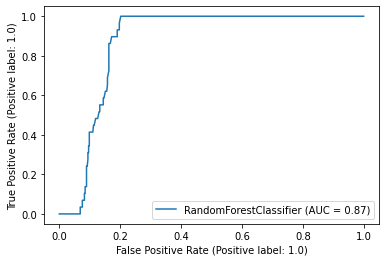

In [40]:
rfc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)


Best Parameters:
 GradientBoostingClassifier(learning_rate=1, random_state=42)
              precision    recall  f1-score   support

         0.0       1.00      0.21      0.34       436
         1.0       0.08      1.00      0.14        29

    accuracy                           0.26       465
   macro avg       0.54      0.60      0.24       465
weighted avg       0.94      0.26      0.33       465

[[ 90 346]
 [  0  29]]


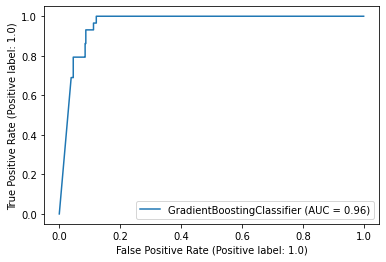

In [41]:
gbc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)


Best Parameters:
 KNeighborsClassifier()
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80       436
         1.0       0.16      0.97      0.28        29

    accuracy                           0.69       465
   macro avg       0.58      0.82      0.54       465
weighted avg       0.94      0.69      0.77       465

[[291 145]
 [  1  28]]


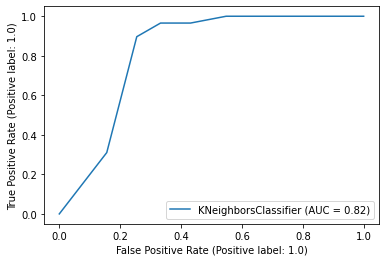

In [42]:
X_train_scale_gen, X_test_scale_gen = scale(df_train_gen, df_test_gen)
knn(X_train_scale_gen, X_test_scale_gen, y_train_gen, y_test_gen)


Best Parameters:
 AdaBoostClassifier(n_estimators=500, random_state=42)
              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90       436
         1.0       0.21      0.69      0.33        29

    accuracy                           0.82       465
   macro avg       0.59      0.76      0.61       465
weighted avg       0.93      0.82      0.86       465

[[362  74]
 [  9  20]]


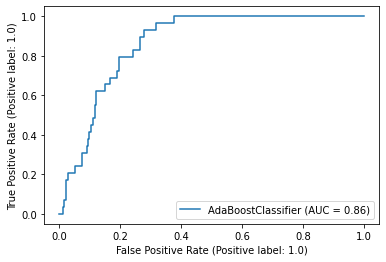

In [43]:
abc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)


Best Parameters:
 SVC(C=1.2, degree=2, gamma='auto', kernel='poly', random_state=42)
              precision    recall  f1-score   support

         0.0       1.00      0.44      0.61       436
         1.0       0.11      1.00      0.19        29

    accuracy                           0.47       465
   macro avg       0.55      0.72      0.40       465
weighted avg       0.94      0.47      0.58       465

[[190 246]
 [  0  29]]


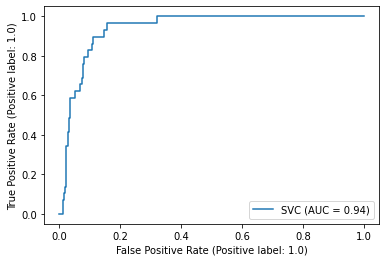

In [45]:
svc(X_train_scale_gen, X_test_scale_gen, y_train_gen, y_test_gen)

# Hydraulic System

In [46]:
feat_drop = ['Date', 'TTF', '60_days', '50_days', '40_days', '30_days', '20_days', '10_days', 'Component', 'Turbine_ID']
X_train_hyd = df_train_hyd.drop(columns=feat_drop)
X_test_hyd = df_test_hyd.drop(columns=feat_drop)
y_train_hyd = df_train_hyd['30_days']
y_test_hyd = df_test_hyd['30_days']


Best Parameters:
 RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=900, random_state=42)
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       421
         1.0       0.00      0.00      0.00        44

    accuracy                           0.91       465
   macro avg       0.45      0.50      0.48       465
weighted avg       0.82      0.91      0.86       465

[[421   0]
 [ 44   0]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

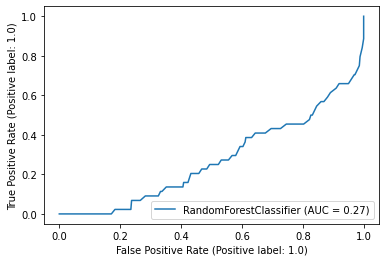

In [47]:
rfc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)


Best Parameters:
 GradientBoostingClassifier(n_estimators=700, random_state=42)
              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85       421
         1.0       0.02      0.05      0.03        44

    accuracy                           0.73       465
   macro avg       0.46      0.43      0.44       465
weighted avg       0.81      0.73      0.77       465

[[339  82]
 [ 42   2]]


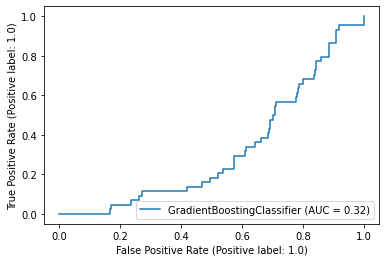

In [48]:
gbc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)


Best Parameters:
 KNeighborsClassifier(weights='distance')
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       421
         1.0       0.08      0.05      0.06        44

    accuracy                           0.86       465
   macro avg       0.49      0.49      0.49       465
weighted avg       0.83      0.86      0.84       465

[[397  24]
 [ 42   2]]


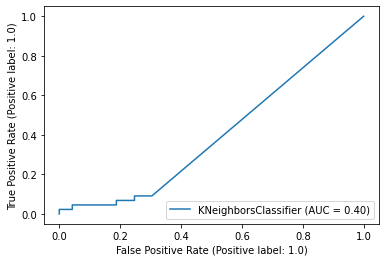

In [49]:
X_train_scale_hyd, X_test_scale_hyd = scale(df_train_hyd, df_test_hyd)
knn(X_train_scale_hyd, X_test_scale_hyd, y_train_hyd, y_test_hyd)


Best Parameters:
 AdaBoostClassifier(random_state=42)
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92       421
         1.0       0.04      0.02      0.03        44

    accuracy                           0.86       465
   macro avg       0.47      0.49      0.48       465
weighted avg       0.82      0.86      0.84       465

[[399  22]
 [ 43   1]]


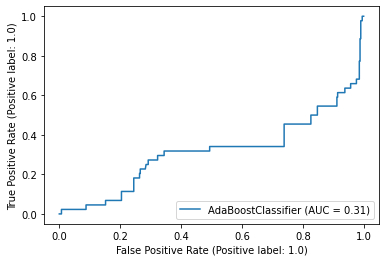

In [50]:
abc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)


Best Parameters:
 SVC(C=1.2, degree=2, gamma='auto', kernel='linear', random_state=42)
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       421
         1.0       0.08      0.05      0.06        44

    accuracy                           0.86       465
   macro avg       0.49      0.49      0.49       465
weighted avg       0.83      0.86      0.84       465

[[397  24]
 [ 42   2]]


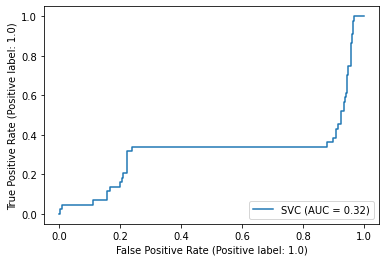

In [51]:
svc(X_train_scale_hyd, X_test_scale_hyd, y_train_hyd, y_test_hyd)

# Transformer

In [56]:
feat_drop = ['Date', 'TTF', '60_days', '50_days', '40_days', '30_days', '20_days', '10_days', 'Component', 'Turbine_ID']
X_train_transf = df_train_transf.drop(columns=feat_drop)
X_test_transf = df_test_transf.drop(columns=feat_drop)
y_train_transf = df_train_transf['30_days']
y_test_transf = df_test_transf['30_days']


Best Parameters:
 RandomForestClassifier(criterion='entropy', n_estimators=750, random_state=42)
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       436
         1.0       0.00      0.00      0.00        29

    accuracy                           0.94       465
   macro avg       0.47      0.50      0.48       465
weighted avg       0.88      0.94      0.91       465

[[436   0]
 [ 29   0]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

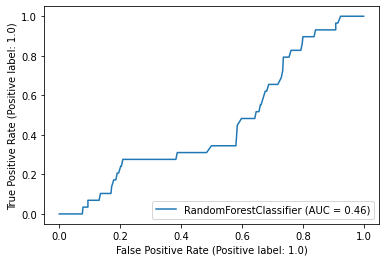

In [57]:
rfc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.01, n_estimators=500,
                           random_state=42)
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96       436
         1.0       0.00      0.00      0.00        29

    accuracy                           0.91       465
   macro avg       0.47      0.49      0.48       465
weighted avg       0.88      0.91      0.90       465

[[425  11]
 [ 29   0]]


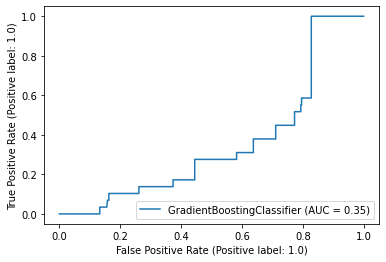

In [58]:
gbc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)


Best Parameters:
 KNeighborsClassifier(n_neighbors=10, weights='distance')
              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86       436
         1.0       0.20      0.93      0.33        29

    accuracy                           0.77       465
   macro avg       0.60      0.84      0.60       465
weighted avg       0.94      0.77      0.83       465

[[330 106]
 [  2  27]]


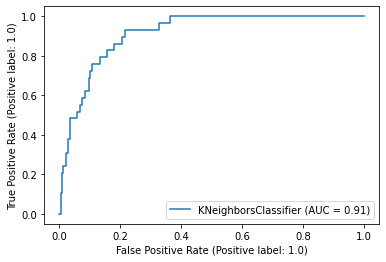

In [59]:
X_train_scale_transf, X_test_scale_transf = scale(df_train_transf, df_test_transf)
knn(X_train_scale_transf, X_test_scale_transf, y_train_transf, y_test_transf)


Best Parameters:
 AdaBoostClassifier(n_estimators=500, random_state=42)
              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90       436
         1.0       0.02      0.03      0.02        29

    accuracy                           0.82       465
   macro avg       0.47      0.45      0.46       465
weighted avg       0.87      0.82      0.85       465

[[381  55]
 [ 28   1]]


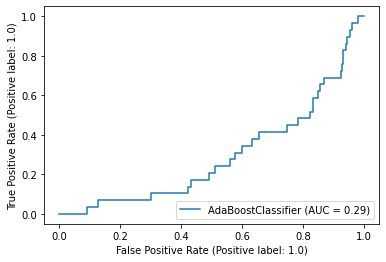

In [60]:
abc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)


Best Parameters:
 SVC(C=1.2, degree=2, gamma='auto', random_state=42)
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98       436
         1.0       1.00      0.24      0.39        29

    accuracy                           0.95       465
   macro avg       0.98      0.62      0.68       465
weighted avg       0.95      0.95      0.94       465

[[436   0]
 [ 22   7]]


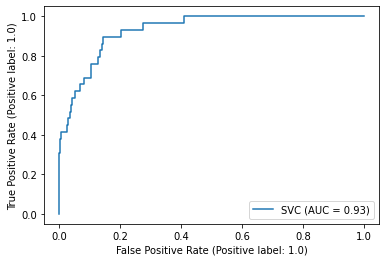

In [61]:
svc(X_train_scale_transf, X_test_scale_transf, y_train_transf, y_test_transf)

# Generator Bearing

In [62]:
feat_drop = ['Date', 'TTF', '60_days', '50_days', '40_days', '30_days', '20_days', '10_days', 'Component', 'Turbine_ID']
X_train_gen_bear = df_train_gen_bear.drop(columns=feat_drop)
X_test_gen_bear = df_test_gen_bear.drop(columns=feat_drop)
y_train_gen_bear = df_train_gen_bear['30_days']
y_test_gen_bear = df_test_gen_bear['30_days']


Best Parameters:
 RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=300, random_state=42)
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       436
         1.0       0.00      0.00      0.00        29

    accuracy                           0.94       465
   macro avg       0.47      0.50      0.48       465
weighted avg       0.88      0.94      0.91       465

[[436   0]
 [ 29   0]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

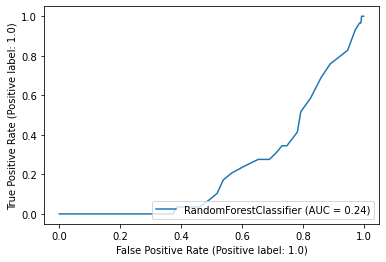

In [63]:
rfc(X_train_gen_bear, X_test_gen_bear, y_train_gen_bear, y_test_gen_bear)


Best Parameters:
 GradientBoostingClassifier(learning_rate=1, random_state=42)
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91       436
         1.0       0.00      0.00      0.00        29

    accuracy                           0.84       465
   macro avg       0.47      0.45      0.46       465
weighted avg       0.87      0.84      0.85       465

[[389  47]
 [ 29   0]]


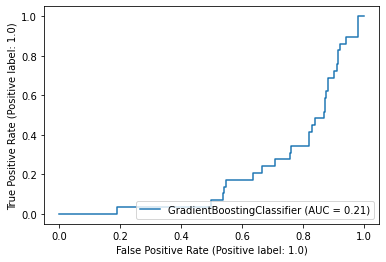

In [64]:
gbc(X_train_gen_bear, X_test_gen_bear, y_train_gen_bear, y_test_gen_bear)


Best Parameters:
 KNeighborsClassifier(n_neighbors=10)
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94       436
         1.0       0.00      0.00      0.00        29

    accuracy                           0.88       465
   macro avg       0.47      0.47      0.47       465
weighted avg       0.88      0.88      0.88       465

[[410  26]
 [ 29   0]]


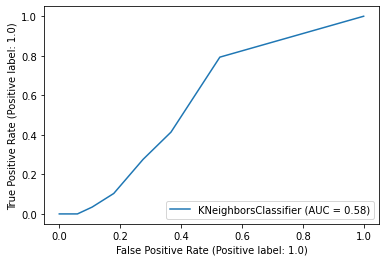

In [65]:
X_train_scale_gen_bear, X_test_scale_gen_bear = scale(df_train_gen_bear, df_test_gen_bear)
knn(X_train_scale_gen_bear, X_test_scale_gen_bear, y_train_gen_bear, y_test_gen_bear)


Best Parameters:
 AdaBoostClassifier(random_state=42)
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       436
         1.0       0.00      0.00      0.00        29

    accuracy                           0.87       465
   macro avg       0.47      0.46      0.46       465
weighted avg       0.87      0.87      0.87       465

[[404  32]
 [ 29   0]]


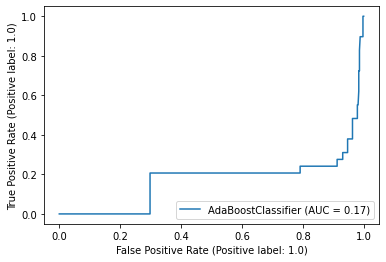

In [66]:
abc(X_train_gen_bear, X_test_gen_bear, y_train_gen_bear, y_test_gen_bear)


Best Parameters:
 SVC(C=0.01, class_weight='balanced', degree=2, gamma='auto', random_state=42)
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       436
         1.0       0.00      0.00      0.00        29

    accuracy                           0.94       465
   macro avg       0.47      0.50      0.48       465
weighted avg       0.88      0.94      0.91       465

[[436   0]
 [ 29   0]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

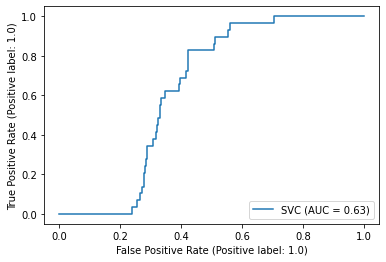

In [67]:
svc(X_train_scale_gen_bear, X_test_scale_gen_bear, y_train_gen_bear, y_test_gen_bear)

## 2nd Analysis

## Bad Results for HYDRAULIC and GEN_BEAR

In [50]:
# def several_models_results(df_train_,df_test_):

#     for key,target_ in dict_mod.items():

#         target=target_
#         df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
#         df_test_[target]=df_test_[target].round().astype(int)#.value_counts()
#         y_test=df_test_[target]
    

#         if 'LogReg' in key:
#             model = 'Logistic Regression'
#             clf_LogReg = LogisticRegression(random_state=42)
#             gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs'], 'class_weight': ['balanced',None]}
#             #gs_score = 'roc_auc' 68
#             gs_score = 'f1'

#             clf_LogReg, pred_LogReg_test, pred_LogReg_train = classifier(model, clf_LogReg, features,target, df_train_,df_test_, params=gs_params, score=gs_score)
#             dict_results[key]=metrics(df_train_[target], pred_LogReg_train['y_train_prob'], df_test_[target], pred_LogReg_test['y_test_pred'], pred_LogReg_test['y_test_prob']).copy()
#             dict_Y_pred_true[key]={'test_true':df_test_[target][:],'train_true':df_train_[target][:],'test_pred':pred_LogReg_test, 'train_pred':pred_LogReg_train}.copy()

#         if  'RF' in key:  
#             model = 'Random Forest'
#             clf_rfc = RandomForestClassifier(n_estimators=50, random_state=42)
#             gs_params = {'max_depth': [3,4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced',None]}
#             gs_score = 'f1'

#             clf_rfc, pred_RandForest_test, pred_RandForest_train = classifier(model, clf_rfc, features,target, df_train_,df_test_,  params=gs_params, score=gs_score)
#             dict_results[key]=metrics(df_train_[target], pred_RandForest_train['y_train_prob'], df_test_[target], pred_RandForest_test['y_test_pred'], pred_RandForest_test['y_test_prob']).copy()
#             dict_Y_pred_true[key]={'test_true':df_test_[target],'train_true':df_train_[target],'test_pred':pred_RandForest_test, 'train_pred':pred_RandForest_train}.copy()


#         if  'KNN' in key:
#             model = 'KNN'
#             clf_knn = KNeighborsClassifier(n_jobs=-1)
#             gs_params = {'n_neighbors': [5, 9 , 10, 11, 12]}
#             gs_score = 'f1'

#             clf_knn, pred_KNN_test, pred_KNN_train = classifier(model, clf_knn, features,target, df_train_,df_test_,  params=gs_params, score=gs_score)
#             dict_results[key]=metrics(df_train_[target], pred_KNN_train['y_train_prob'], df_test_[target], pred_KNN_test['y_test_pred'], pred_KNN_test['y_test_prob']).copy()
#             dict_Y_pred_true[key]={'test_true':df_test_[target],'train_true':df_train_[target],'test_pred':pred_KNN_test, 'train_pred':pred_KNN_train}.copy()
    
#         print(key)

#     return dict_results, dict_Y_pred_true

In [51]:
# dict_modxxx={
# #     'LogReg_60':'60_days',
# #     'LogReg_50':'50_days',
# #     'LogReg_40':'40_days',
# #     'LogReg_30':'30_days',
# #     'LogReg_20':'20_days',
# #     'LogReg_10':'10_days',
    
#     'RF_60':'60_days',
#     'RF_50':'50_days',
#     'RF_40':'40_days',
#     'RF_30':'30_days',
#     'RF_20':'20_days',
#     'RF_10':'10_days',
    
#     'KNN_60':'60_days',
#     'KNN_50':'50_days',
#     'KNN_40':'40_days',
#     'KNN_30':'30_days',
#     'KNN_20':'20_days',
#     'KNN_10':'10_days'    

#         }


# dict_mod={
#     'LogReg_60':'60_days',
#     'LogReg_50':'50_days',
#     'LogReg_40':'40_days',
#     'LogReg_30':'30_days',
#     'LogReg_20':'20_days',
#     'LogReg_10':'10_days',
    
#     'RF_60':'60_days',
#     'RF_50':'50_days',
#     'RF_40':'40_days',
#     'RF_30':'30_days',
#     'RF_20':'20_days',
#     'RF_10':'10_days'
      
#         }

# dict_mod__={
#     'LogReg_60':'60_days',
#     'LogReg_30':'30_days',
#     'LogReg_10':'10_days',
    
#     'RF_60':'60_days',
#     'RF_30':'30_days',
#     'RF_10':'10_days',
    
#     'KNN_60':'60_days',
#     'KNN_30':'30_days',
#     'KNN_10':'10_days'    
#         }


In [52]:
# dict_df_ = {'generator_results':(df_train_generator,df_test_generator),
#            'hydraulic_results':(df_train_hydraulic, df_test_hydraulic)}
#            #'genbear_results':(df_train_gen_bear,df_test_gen_bear)}


# dict_df = {'generator_results':(df_train_generator,df_test_generator),
#            'hydraulic_results':(df_train_hydraulic, df_test_hydraulic),
#            'genbear_results':(df_train_gen_bear,df_test_gen_bear), 
#            'transformer_results':(df_train_transformer,df_test_transformer),
#            'gearbox_results':(df_train_gearbox,df_test_gearbox)}

In [53]:
# dict_results={}
# dict_Y_pred_true={}


# dict_results_by_component={}
# dict_Y_pred_true_by_component={}

# for   key,df_ in dict_df.items():
 
#     df_train_=df_[0]
#     df_test_=df_[1]
#     features=df_[0].drop(columns=['60_days', '50_days', '40_days', '30_days', '20_days', '10_days', 'Date', 'Turbine_ID', 'Component', 'TTF','Component_av','Component_sd']).columns

   
#     dict_results_by_component[key]=pd.DataFrame(several_models_results(df_train_,df_test_)[0]).copy()
#     dict_Y_pred_true_by_component[key]=several_models_results(df_train_,df_test_)[1].copy()
#     print(key)
#     print(dict_Y_pred_true_by_component.keys())

In [54]:
#dict_results_by_component['generator_results']

In [55]:
# for component in dict_results_by_component.keys():
#     for model in dict_mod.keys():
#         print(" ")
#         print(f'{component+" "+model}')
#         print(" ")
#         roc_curve_plot (dict_Y_pred_true_by_component[component][model]['test_true'],  dict_Y_pred_true_by_component[component][model]['test_pred']['y_test_prob'].values)
#         plt.show()

In [56]:
# for component in dict_results_by_component.keys():
#     for model in dict_mod.keys():
        
#         df_boxplot=pd.DataFrame(dict_Y_pred_true_by_component[component][model]['test_true'].values,
#         dict_Y_pred_true_by_component[component][model]['test_pred']['y_test_prob']).reset_index().rename(columns={0:'y_test_true'})
#         print(" ")
#         print(f'{component+" "+model}')
#         print(" ")
#         sns.boxplot(x="y_test_true", y="y_test_prob", data=df_boxplot)
        
#         plt.show()